In [1]:
# Environment Setup
!pip install librosa pandas matplotlib scikit-learn tqdm

In [2]:
import tensorflow as tf
import numpy as np


In [3]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [4]:
# Configuration
DATA_PATH = r"F:\Firefox downloader\Projects\Project 2 - Music Genre Indentification\genres"
SAMPLE_RATE = 22050
DURATION = 30  # Seconds
N_MELS = 128
N_MFCC = 40
MAX_FRAMES = 130  # For padding/truncation
BATCH_SIZE = 32
EPOCHS = 50


In [5]:
# Feature Extraction Function
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
        log_mel = librosa.power_to_db(mel, ref=np.max)
        
        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        
        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # Stack features
        features = np.vstack([log_mel, mfcc, chroma, contrast])
        
        # Pad/Truncate
        if features.shape[1] < MAX_FRAMES:
            features = np.pad(features, ((0,0), (0, MAX_FRAMES - features.shape[1])), mode='constant')
        else:
            features = features[:, :MAX_FRAMES]
            
        return features.T  # Transpose to (time, features)
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

In [6]:
# Dataset Preparation
genres = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
audio_files = []
labels = []

for genre in genres:
    genre_path = os.path.join(DATA_PATH, genre)
    files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.au')]
    audio_files.extend(files)
    labels.extend([genre] * len(files))

# Extract features
X = []
y = []

for file, label in tqdm(zip(audio_files, labels), total=len(audio_files)):
    features = extract_features(file)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(genres))

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:33<00:00,  3.65it/s]


In [7]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    
    # Feed Forward Network
    y = layers.Dense(ff_dim, activation="relu")(x)
    y = layers.Dense(inputs.shape[-1])(y)
    y = layers.Dropout(dropout)(y)
    return layers.LayerNormalization(epsilon=1e-6)(x + y)

In [8]:
# Hybrid CNN-Transformer Model
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # CNN Feature Extraction
    x = layers.Reshape((*input_shape, 1))(inputs)  # Add channel dimension
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Prepare for Transformer
    _, height, width, channels = x.shape
    x = layers.Reshape((height * width, channels))(x)
    
    # Positional Encoding
    positions = tf.range(start=0, limit=height * width, delta=1)
    position_embedding = layers.Embedding(
        input_dim=height * width, output_dim=channels)(positions)
    x = x + position_embedding
    
    # Transformer Blocks
    x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=256)
    x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=256)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classification Head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs, outputs)

model = build_model(input_shape=(MAX_FRAMES, N_MELS + N_MFCC + 12 + 7),  # Dimensions of stacked features
                    num_classes=len(genres))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 187)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 130, 187, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 130, 187, 32  320         ['reshape[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 65, 93, 32)   0           ['conv2d[0][0]']             

In [9]:
# Model Training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/50
25/25 [==============================] - 10s 109ms/step - loss: 2.4681 - accuracy: 0.1063 - val_loss: 2.3254 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 2s 70ms/step - loss: 2.3458 - accuracy: 0.1013 - val_loss: 2.3172 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 2s 70ms/step - loss: 2.3131 - accuracy: 0.0938 - val_loss: 2.3034 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 2s 70ms/step - loss: 2.3044 - accuracy: 0.0900 - val_loss: 2.3032 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 2s 69ms/step - loss: 2.3028 - accuracy: 0.1025 - val_loss: 2.3045 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 2s 79ms/step - loss: 2.3021 - accuracy: 0.0975 - val_loss: 2.3016 - val_accuracy: 0.1150 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 2s 69ms/step - loss: 2

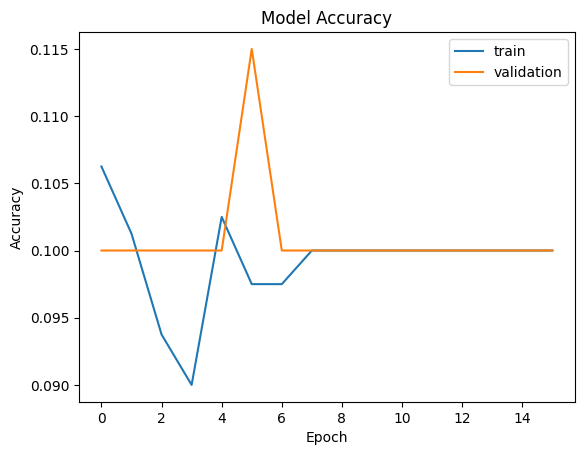

7/7 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.15      0.95      0.26        20
     country       0.00      0.00      0.00        20
       disco       0.00      0.00      0.00        20
      hiphop       0.14      0.20      0.16        20
        jazz       0.00      0.00      0.00        20
       metal       0.00      0.00      0.00        20
         pop       0.00      0.00      0.00        20
      reggae       0.00      0.00      0.00        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.12       200
   macro avg       0.03      0.11      0.04       200
weighted avg       0.03      0.12      0.04       200



C:\Users\Yasi Kasmi\anaconda3\envs\tf-gpu-clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Yasi Kasmi\anaconda3\envs\tf-gpu-clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Yasi Kasmi\anaconda3\envs\tf-gpu-clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [10]:
# Evaluation
model.load_weights("best_model.h5")  # Load best model

# Plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Classification Report
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(
    y_true_classes, y_pred_classes, 
    target_names=le.classes_
))

In [11]:
# Save Model
model.save("genre_classifier_transformer.h5")
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)